# (04) fit — iterative pvae

**Motivation**: host = ```mach```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE



import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

## Poisson Omniglot + Amortized, MLP decoder

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('Omniglot', model_type, 'mlp|mlp')

seq_len = 1

cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = seq_len

cfg_tr['kl_beta'] = 1.0

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

tr.n_iters

96000

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  933.2 K   |
|     ———     |    ———     |
|    layer    |  933.2 K   |
+-------------+------------+

poisson_Omniglot_t-1_z-[128]_<mlp|mlp>
b200-ep1000-lr(0.002)_beta(1:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_14,16:33)

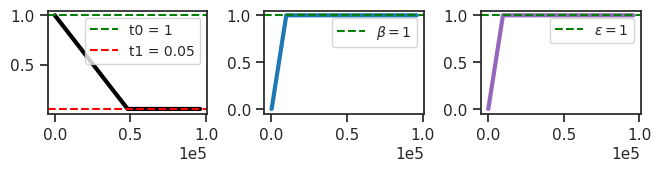

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  933.2 K   |
|     ———      |    ———     |
|     enc      |  465.9 K   |
|     dec      |  467.1 K   |
+--------------+------------+

In [7]:
print(tr.model.layer.dec)

Sequential(
  (0): Linear(in_features=128, out_features=234, bias=True)
  (1): SiLU(inplace=True)
  (2): Linear(in_features=234, out_features=428, bias=True)
  (3): SiLU(inplace=True)
  (4): Linear(in_features=428, out_features=784, bias=True)
)

### Fit model

In [8]:
tr.train()

epoch # 1000, avg loss: 45.926605: 100%|████| 1000/1000 [15:23<00:00,  1.08it/s]


**Task:** Omniglot, Amortized, $(T, \beta) = (1, 1.0)$, MLP decoder

In [14]:
print(tr.model.layer.n_exp)

tensor([13], device='cuda:0', dtype=torch.int32)

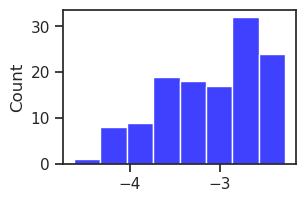

In [15]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
sns.histplot(log_rate, color='b');

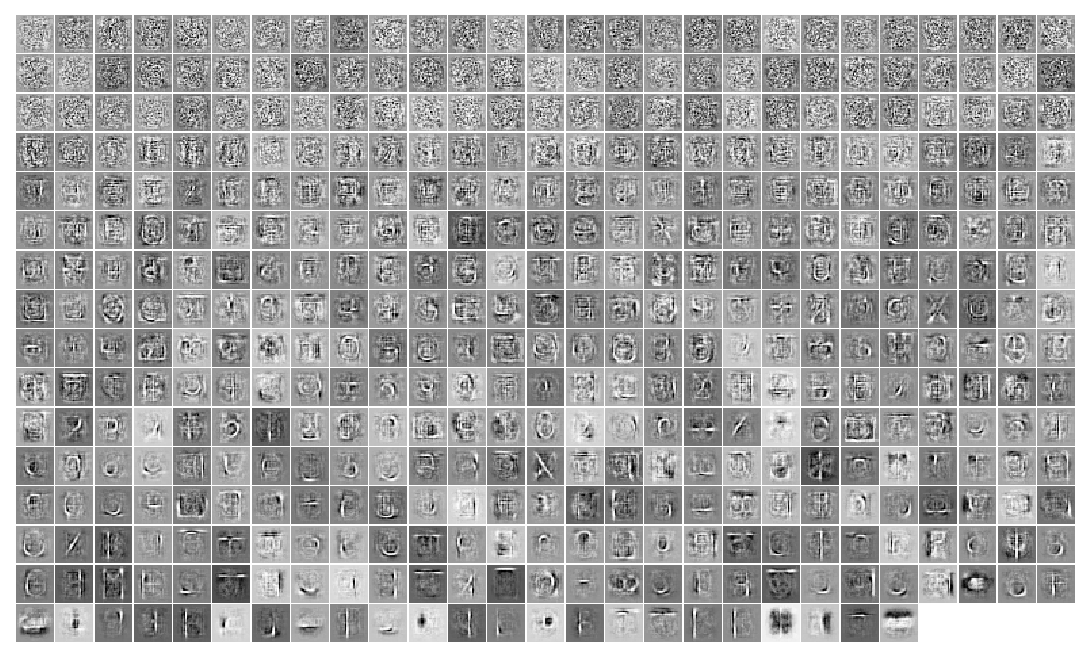

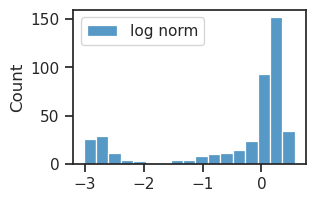

In [16]:
w = tr.model.layer.get_weight()
norms = tonp(torch.linalg.vector_norm(w, dim=1))

_ = tr.model.show(order=np.argsort(norms))

sns.histplot(np.log(norms), label='log norm')
plt.legend()
plt.show()

In [17]:
dead = log_rate > 10.5
dead.sum()

0

100%|████████████████████████████████| 66/66 [00:00<00:00, 251.74it/s]
/home/hadi/anaconda3/lib/python3.11/site-packages/matplotlib/transforms.py:2653: RuntimeWarning: divide by zero encountered in scalar divide
  y_scale = 1.0 / inh


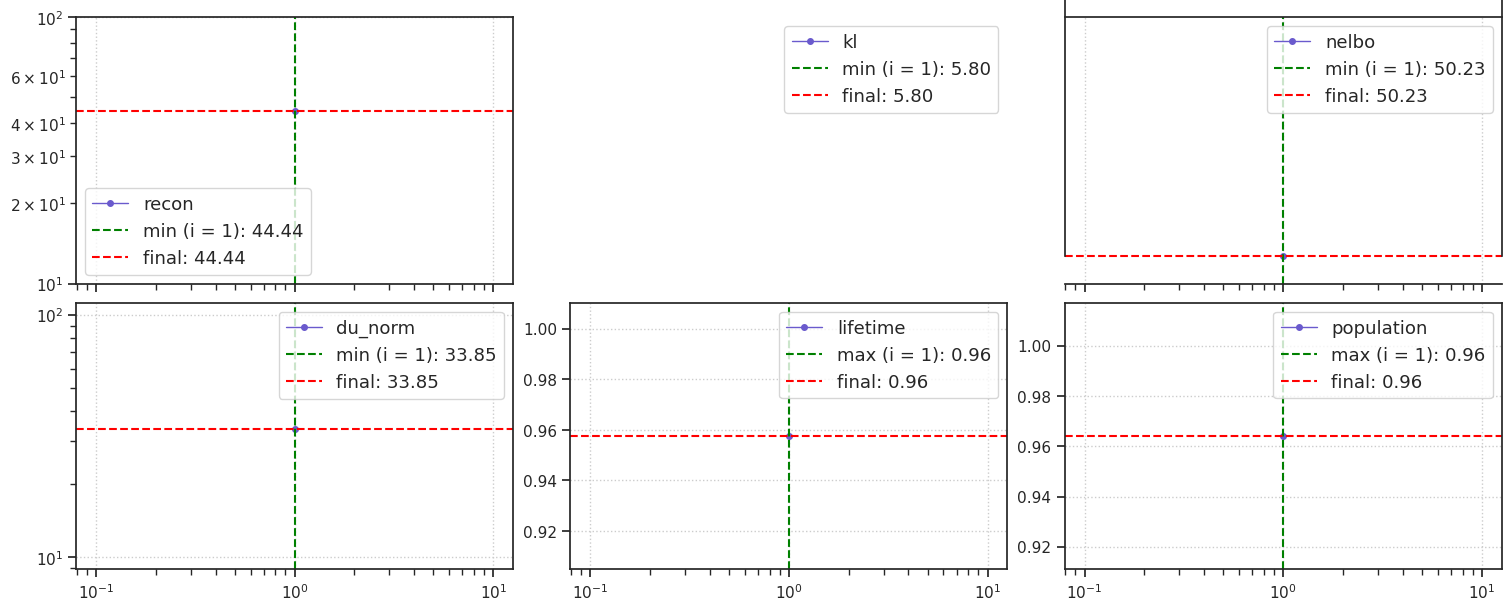

CPU times: user 2.22 s, sys: 66.1 ms, total: 2.29 s
Wall time: 2.28 s


In [18]:
%%time

kws = dict(
    # seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = tr.analysis(**kws)
_ = plot_convergence(results, color='slateblue')

## Poisson Omniglot + Amortized, linear decoder

### Get configs

In [4]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('Omniglot', model_type, 'lin|lin')

seq_len = 1

cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = seq_len

cfg_tr['kl_beta'] = 1.0

### Make model + trainer

In [5]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

tr.n_iters

96000

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  803.8 K   |
|     ———     |    ———     |
|    layer    |  803.8 K   |
+-------------+------------+

poisson_Omniglot_t-1_z-[512]_<lin|lin>
b200-ep1000-lr(0.002)_beta(1:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_14,16:07)

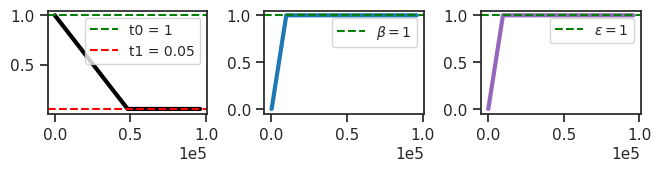

In [6]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [7]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  803.8 K   |
|     ———      |    ———     |
|    fc_enc    |  401.4 K   |
|    fc_dec    |  401.4 K   |
+--------------+------------+

In [8]:
print(tr.model.layer.dec)

None

### Fit model

In [9]:
tr.train()

epoch # 1000, avg loss: 47.650124: 100%|████| 1000/1000 [12:05<00:00,  1.38it/s]


**Task:** Omniglot, Amortized, $(T, \beta) = (1, 1.0)$

In [11]:
print(tr.model.layer.n_exp)

tensor([11], device='cuda:0', dtype=torch.int32)

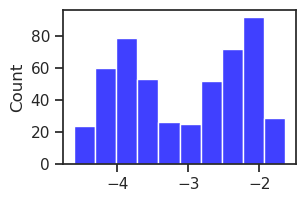

In [12]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
sns.histplot(log_rate, color='b');

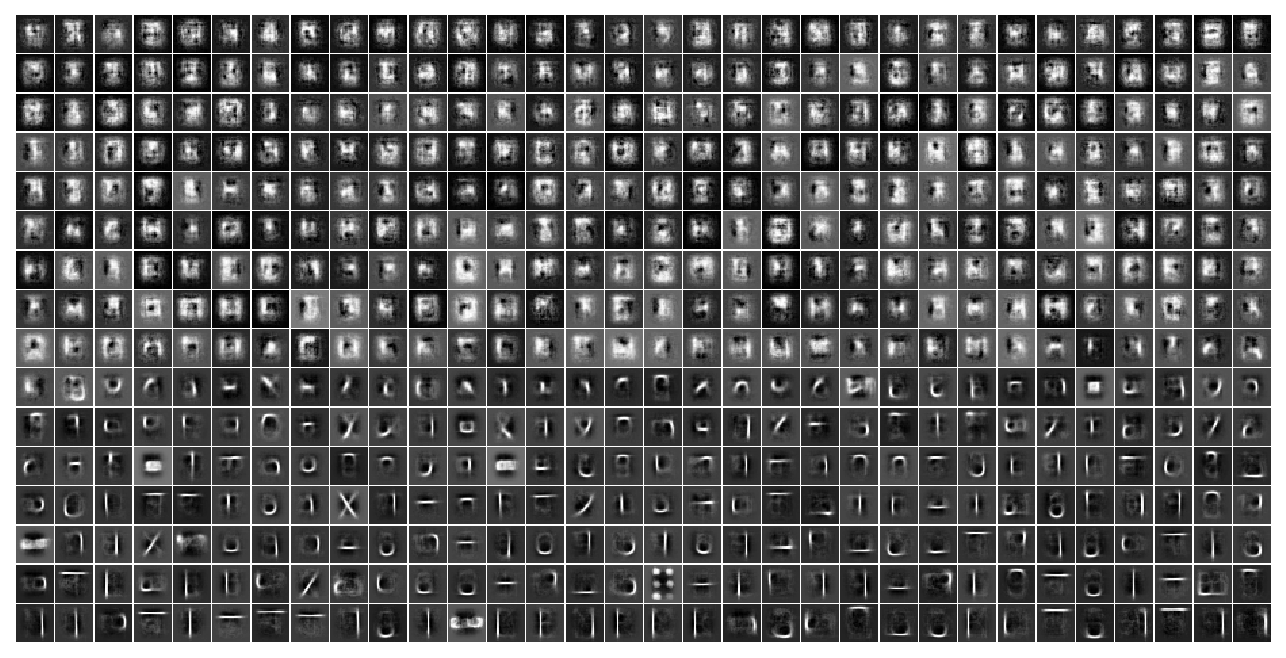

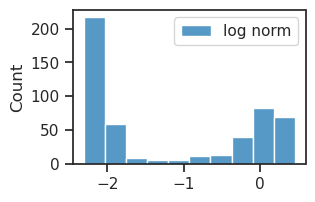

In [13]:
w = tr.model.layer.get_weight()
norms = tonp(torch.linalg.vector_norm(w, dim=1))

_ = tr.model.show(order=np.argsort(norms))

sns.histplot(np.log(norms), label='log norm')
plt.legend()
plt.show()

In [14]:
dead = log_rate > 1.5
dead.sum()

0

100%|████████████████████████████████| 66/66 [00:00<00:00, 368.60it/s]


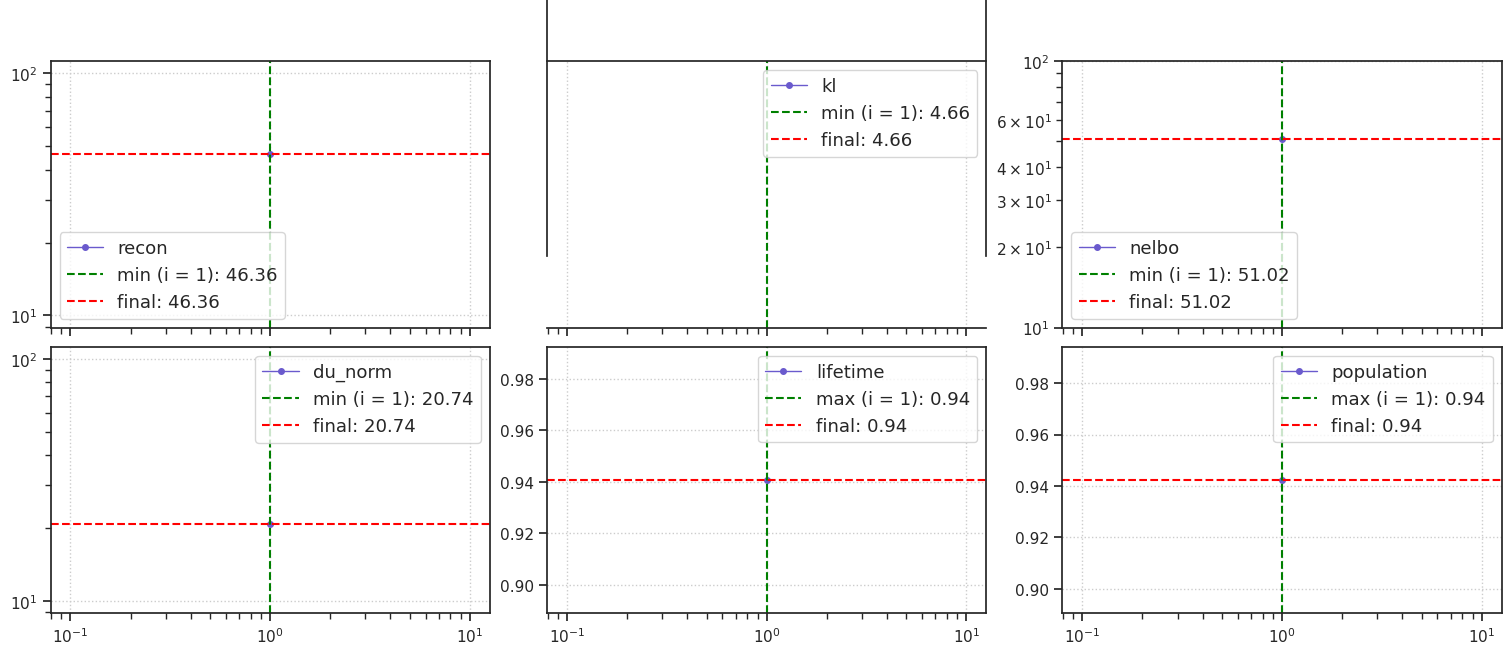

CPU times: user 1.54 s, sys: 62.1 ms, total: 1.6 s
Wall time: 1.6 s


In [16]:
%%time

kws = dict(
    # seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = tr.analysis(**kws)
_ = plot_convergence(results, color='slateblue')

## Poisson Omniglot, linear decoder

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('Omniglot', model_type, 'jacob|lin')

seq_len = 16

cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = seq_len

cfg_tr['kl_beta'] = 2/4 * seq_len

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

tr.n_iters

96000

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  402.4 K   |
|     ———     |    ———     |
|    layer    |  402.4 K   |
+-------------+------------+

poisson_Omniglot_t-16_z-[512]_<jacob|lin>
b200-ep1000-lr(0.002)_beta(8:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_14,11:27)

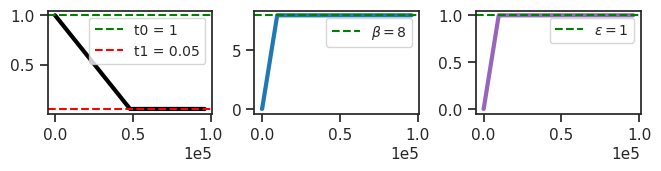

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  402.4 K   |
|     ———      |    ———     |
|    fc_dec    |  401.4 K   |
+--------------+------------+

In [7]:
print(tr.model.layer.dec)

None

### Fit model

In [8]:
tr.train()

epoch # 1000, avg loss: 27.757432: 100%|██| 1000/1000 [1:26:46<00:00,  5.21s/it]


**Task:** Omniglot, $(T, \beta) = (16, 8.0)$

- Done: Omniglot, $T = 8, \,\, \beta = 4.0,$

- Done: Larger beta? $T = 64, \,\, \beta = 80.0, $ was failure.

- Done: longer seq for vH16:
    - $T = 64, \,\, \beta = 32.0,$

In [10]:
print(tr.model.layer.n_exp)

tensor([11, 14, 17, 22, 26, 30, 34, 36, 38, 40, 41, 42, 42, 42, 42, 42],
       device='cuda:0', dtype=torch.int32)

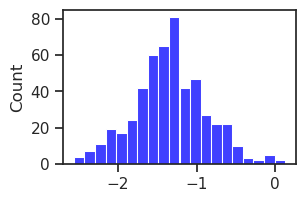

In [11]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
sns.histplot(log_rate, color='b');

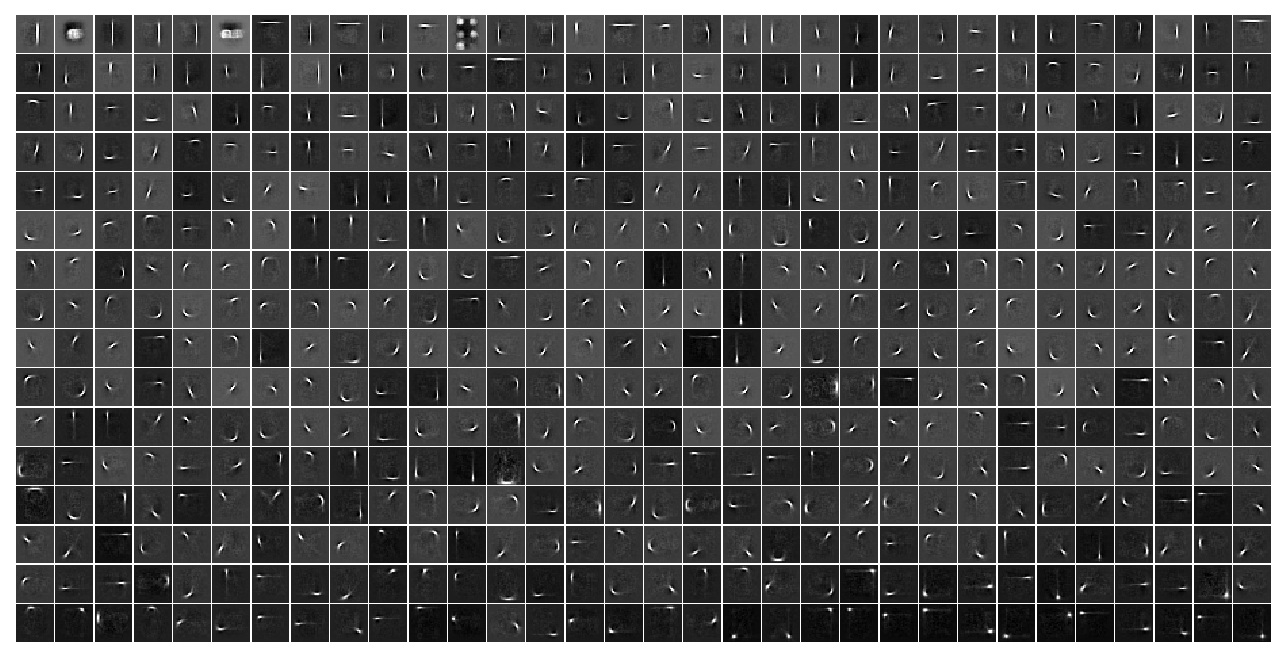

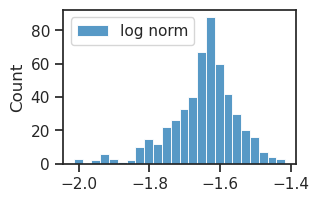

In [12]:
w = tr.model.layer.get_weight()
norms = tonp(torch.linalg.vector_norm(w, dim=1))

_ = tr.model.show(order=np.argsort(norms))

sns.histplot(np.log(norms), label='log norm')
plt.legend()
plt.show()

In [13]:
dead = log_rate > 1.5
dead.sum()

0

100%|█████████████████████████████████| 66/66 [04:02<00:00,  3.67s/it]


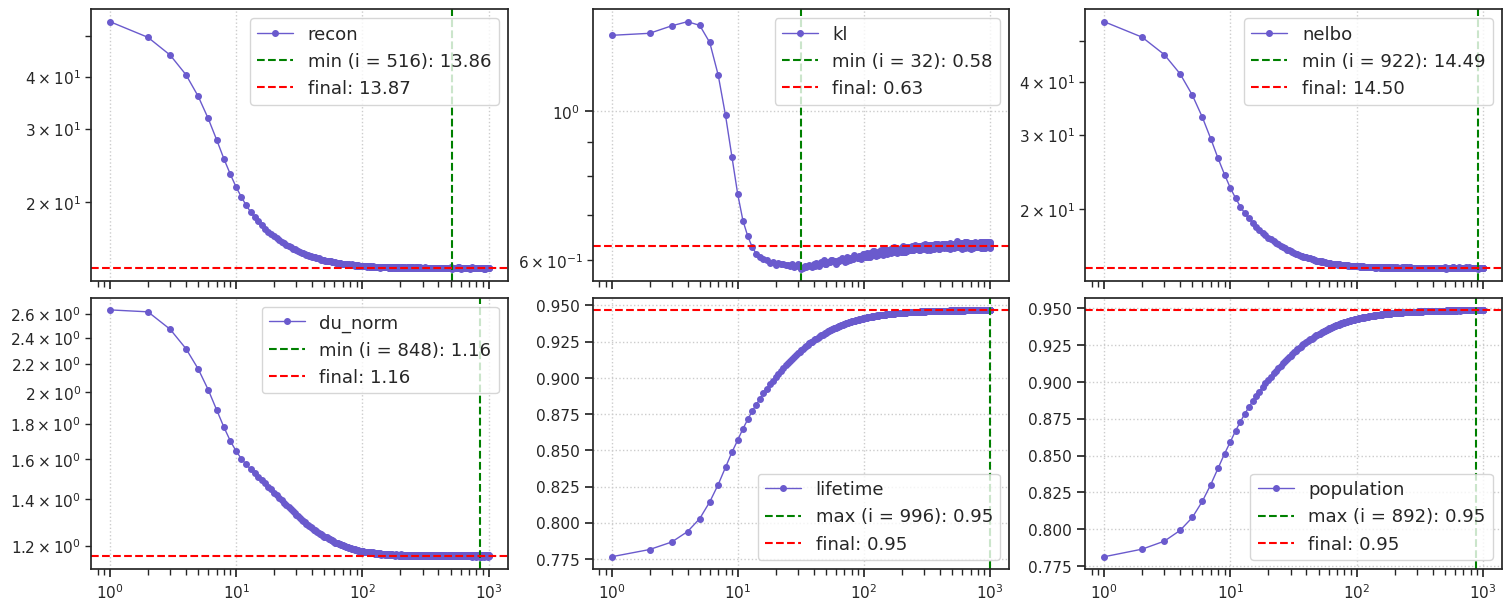

CPU times: user 3min 57s, sys: 13.1 s, total: 4min 10s
Wall time: 4min 10s


In [14]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = tr.analysis(**kws)
_ = plot_convergence(results, color='slateblue')

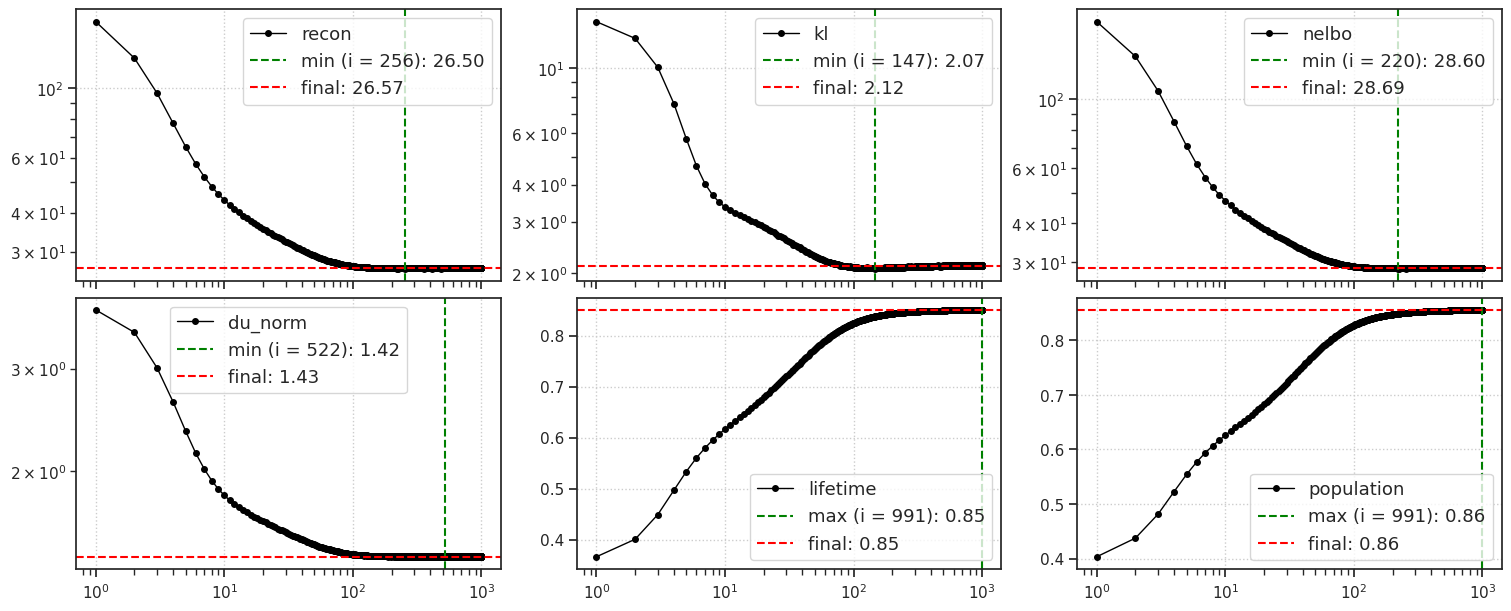

In [13]:
## Was: <jac|lin>, 8/4.0

## MNIST

### Load model

In [3]:
model_name = 'poisson_uniform_c(-2)_MNIST_t-8_z-[32]_k-32_<jacob|conv+b>'
fit_name = 'b200-ep500-lr(0.002)_beta(2:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_09_06,22:41)'
tr, meta = load_model(model_name, fit_name, device=device)
meta['checkpoint']

500

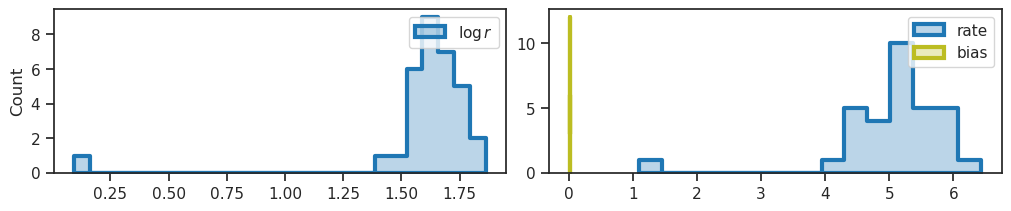

In [4]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [5]:
dead = log_rate < 0.5
dead.sum(), (~dead).sum(), dead.sum() / len(dead)

(1, 31, 0.03125)

In [6]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=100,
    n_data_batches=None,
    active=~dead,
    # full_data=True,
    # return_recon=True,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['vld'] # 'trn', 'tst']
}

100%|█████████████████████████████████| 50/50 [16:04<00:00, 19.29s/it]


CPU times: user 15min 56s, sys: 3.02 s, total: 15min 59s
Wall time: 16min 5s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

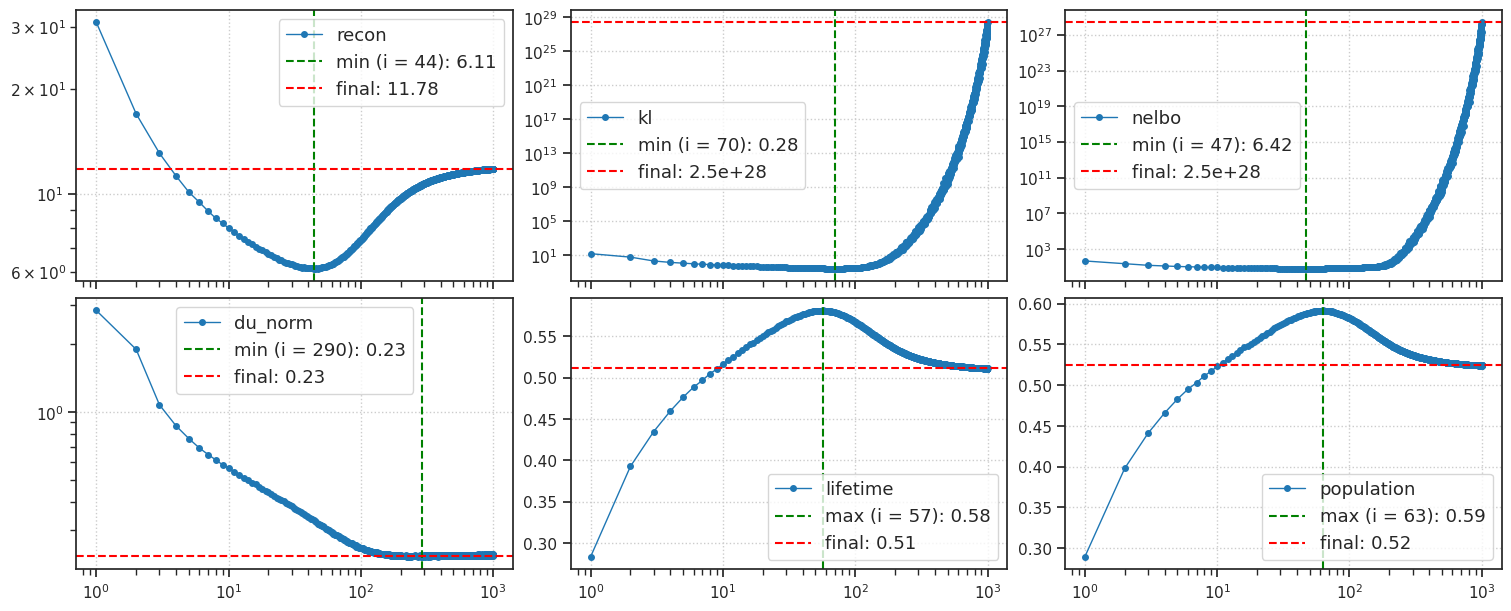

In [10]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    if name != 'trn':
        print('\n\n\n')
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

In [11]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=100,
    n_data_batches=1,
    active=~dead,
    full_data=True,
    return_recon=True,
)
results_to_plot = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['trn', 'vld'] # , 'tst']
}

100%|███████████████████████████████████| 1/1 [00:39<00:00, 39.83s/it]


CPU times: user 1min 32s, sys: 3.26 s, total: 1min 35s
Wall time: 1min 21s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

trn

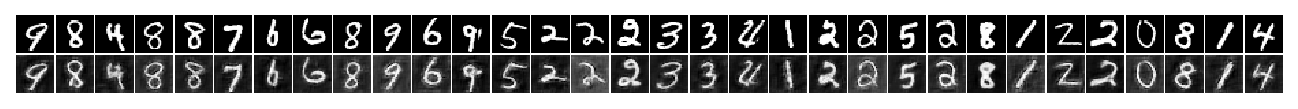

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

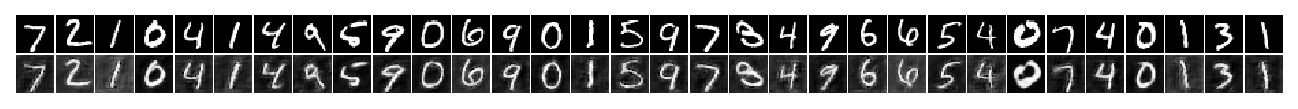

In [12]:
num = 32
shape = (tr.model.cfg.input_sz, ) * 2

for name, d in results_to_plot.items():
    print('_' * 110)
    print('-' * 110)
    print(name)
    
    x2p = np.concatenate([
        d['x'][:num, 0],
        d['y'][:num, -1].reshape(-1, *shape),
    ])
    _ = plot_weights(x2p, nrows=2)

### generate

In [13]:
n_samples = 64
tr.model.reset_state(n_samples)
tr.model.update_pred(temp=0.0)
pred = tr.model.pred

output = tr.model.generate(pred, seq=range(300))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['ff', 'dist', 'samples', 'recon', 'loss_kl', 'loss_recon']

In [14]:
shape = (tr.model.cfg.input_sz, tr.model.cfg.input_sz)

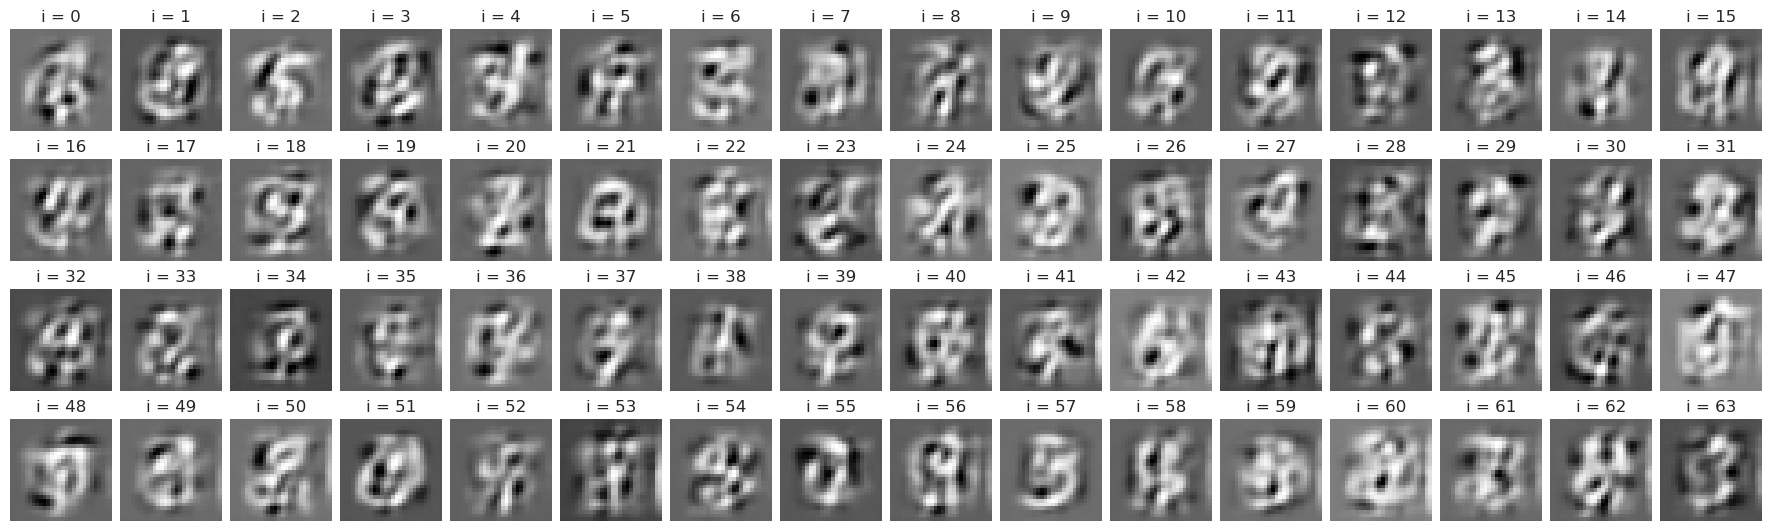

In [15]:
nrows = 4
ncols = int(np.ceil(n_samples / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')
for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    x2p = tonp(pred[sample_i].reshape(shape))
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")
trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [16]:
sample_i = 27

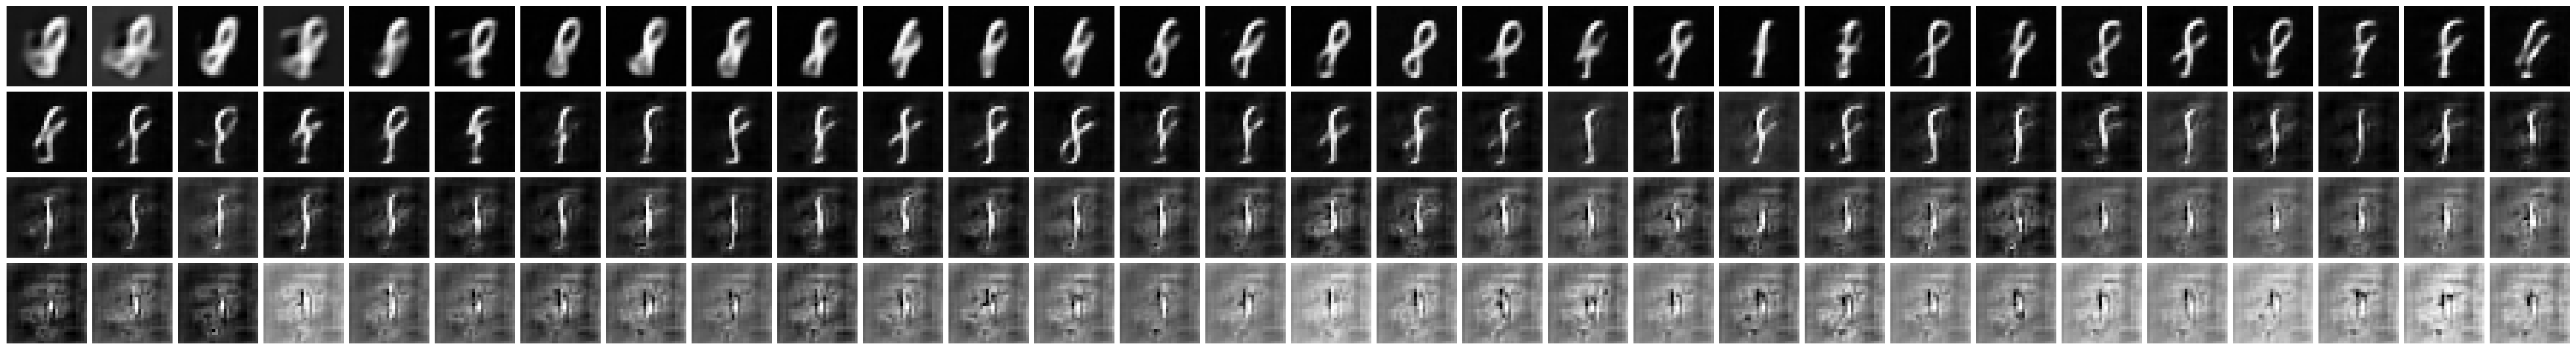

In [17]:
nrows, ncols = 4, 30
fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all')
for idx, ax in enumerate(axes.flat):
    i, j = idx // ncols, idx % ncols
    x2p = tonp(output['recon'][sample_i, idx].reshape(shape))
    ax.imshow(x2p, cmap='Greys_r')
remove_ticks(axes)

In [18]:
order = np.argsort(desc_len)[::-1]

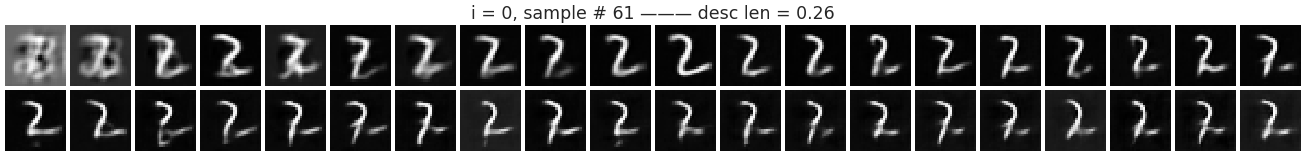

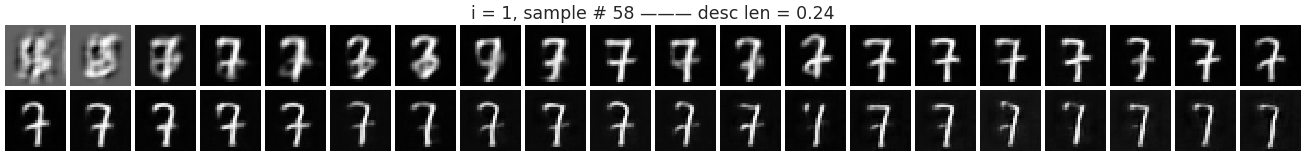

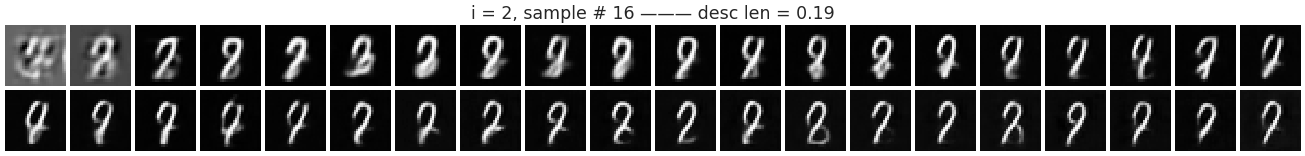

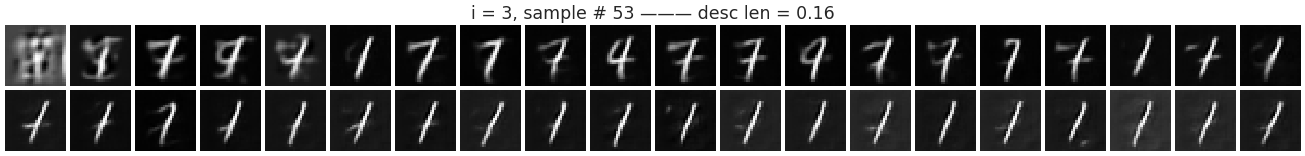

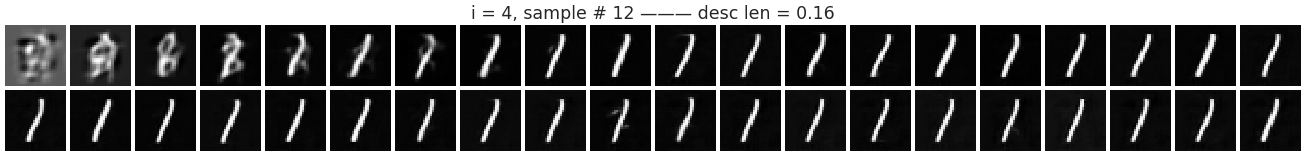

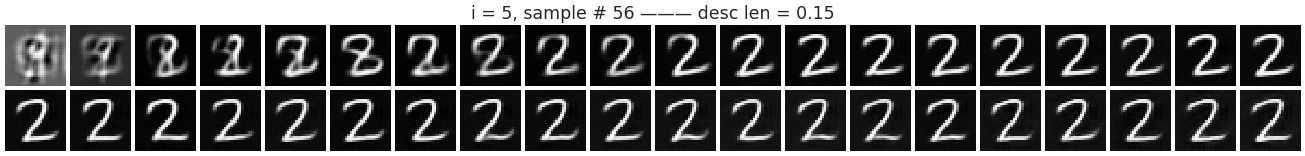

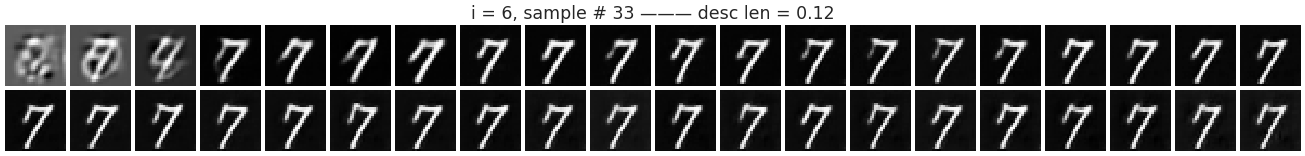

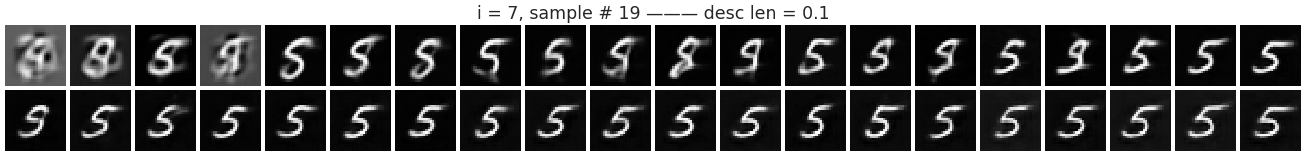

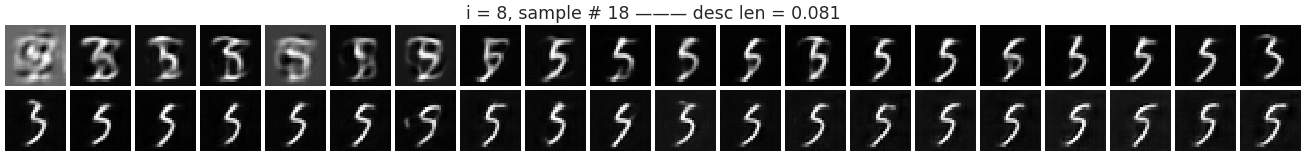

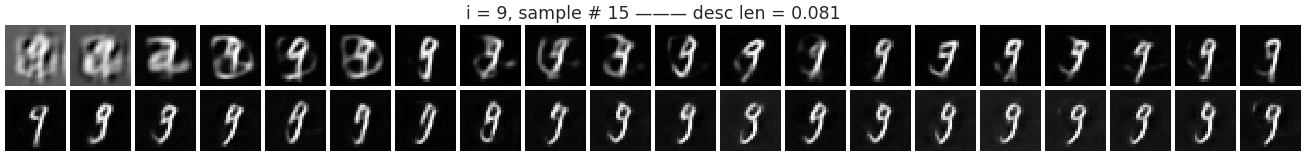

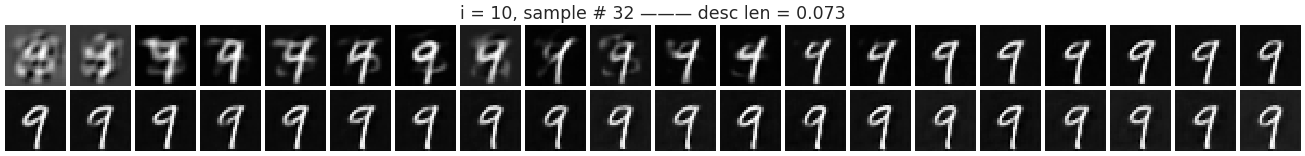

In [19]:
for i in range(len(pred)):
    if i > 10:
        continue
    sample_i = order[i]
    nrows, ncols = 2, 20
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=50)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i].reshape(shape))
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(output['recon'][sample_i, idx - 1].reshape(28, 28))
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()